# Produce lifetime XY map

### Run 5881: 21-06-2018 
- Open castle, recover lifetime
- pressure: 10 bar
- Gate voltage: 8 kV

### Notebook configuration

In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [65]:
import os
import time
import datetime
import collections
import glob

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string


from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [95]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from core.kr_types import Ndst, EffDst
from   invisible_cities.evm  .ic_containers  import Measurement

In [68]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [69]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [70]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [71]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Wed Jun 27 20:46:00 2018


### Files

In [74]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/dst"
opath = f"/Users/jjgomezcadenas/Projects/ICDEV/maps"
run_number          = 5881
input_dst_filename  = f"{path}/dst_{run_number}.h5"


print(f"run number = {run_number}")
print(f"input dst = {input_dst_filename}")


run number = 5881
input dst = /Users/jjgomezcadenas/Projects/ICDEV/dst/dst_5881.h5


In [75]:
output_dst_filename = f"{opath}/lt_{run_number}.h5"
print(f"output dst = {output_dst_filename}")

output dst = /Users/jjgomezcadenas/Projects/ICDEV/maps/lt_5881.h5


### Read data

In [86]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst            = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst_full.event.duplicated()

number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 398658


In [87]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [88]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-220,  220),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   60,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [89]:
print(krRanges, krNBins)

KrRanges(E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), Z=(100, 550), T=(datetime.datetime(2018, 6, 20, 16, 56, 43, 292000), datetime.datetime(2018, 6, 22, 13, 5, 24, 408000)), XY=(-220, 220)) KrNBins(E=50, S1=20, Q=25, Z=10, T=44, XY=60)


In [97]:
XYpitch    = np.diff(krBins.XY)[0] 

### Fiducial volumes

In [90]:
R_full   = 190
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 190: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [91]:
dst_full   = dst[dst.R < R_full]
dst_fid    = dst[dst.R < R_fid]
dst_core   = dst[dst.R < R_core]
dst_hcore  = dst[dst.R < R_hcore]

n_dst  = len(dst)

ndst = Ndst(full  = len(dst_full), 
            fid   = len(dst_fid), 
            core  = len(dst_core), 
            hcore = len(dst_hcore))

effdst = EffDst(full  = ndst.full  / n_dst, 
                fid   = ndst.fid   / n_dst, 
                core  = ndst.core  / n_dst, 
                hcore = ndst.hcore / n_dst)
print(ndst)
print(effdst)

Ndst(full=1526837, fid=1003221, core=446129, hcore=111820)
EffDst(full=1.0, fid=0.6570583500399846, core=0.29219163538740545, hcore=0.07323637035256547)


In [96]:
kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))

### Event distribution

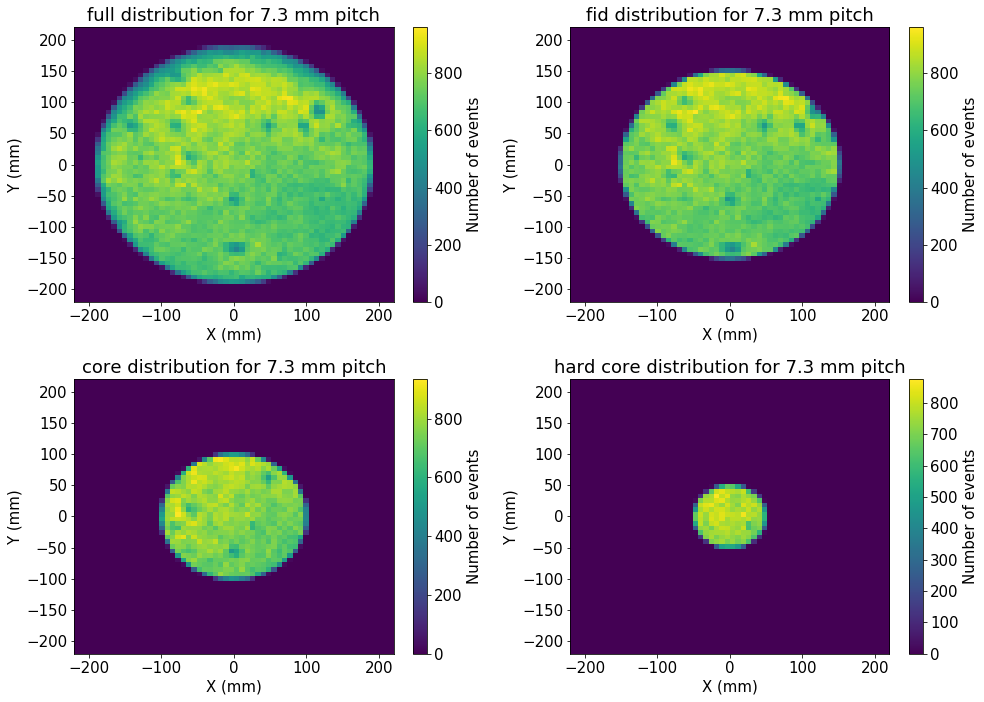

In [98]:
nEvt = krp.plot_xy_density(kdst, krBins, XYpitch)

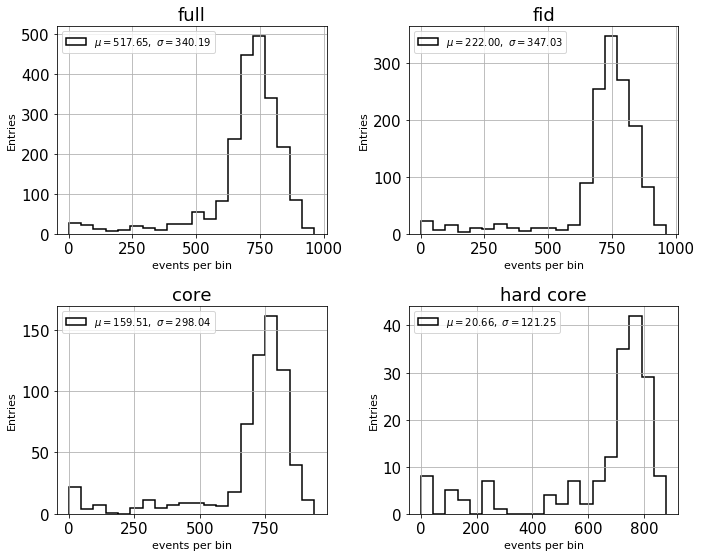

In [102]:
krh.h1n(n=4, nx=2, ny=2, 
    h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
    bins = (20, 20, 20, 20),
    ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
              (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
    xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
    ylabels = ("Entries", "Entries", "Entries", "Entries"),
    titles = ("full", "fid", "core", "hard core"),
    legends = ("upper left", "upper left", "upper left", "upper left"),
    figsize =(10,8))

### Evolution of S12 with time full

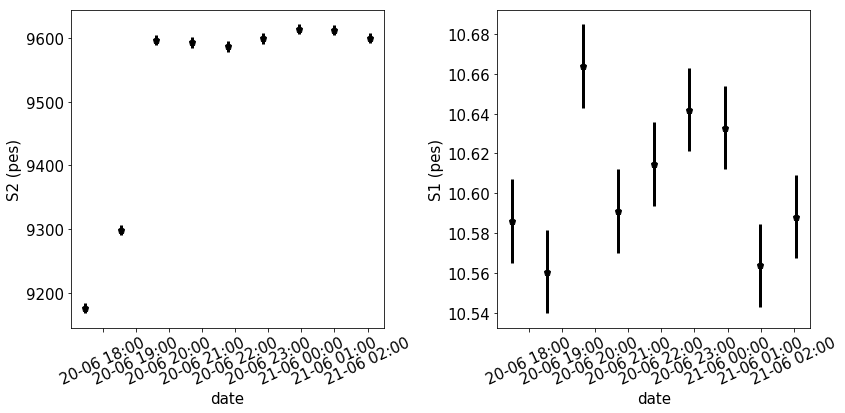

In [106]:
krf.s12_time_profile(kdst.full, Tnbins, Trange, timeStamps, figsize=(12,6))

### Evolution of S12 with time hard core

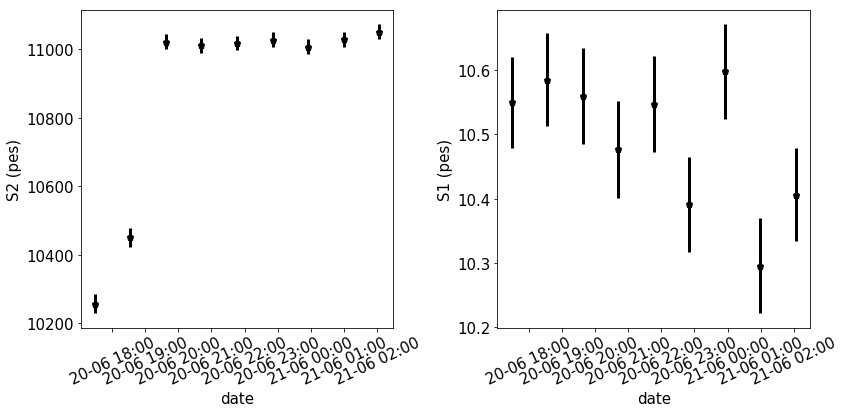

In [109]:
krf.s12_time_profile(kdst.hcore, Tnbins, Trange, timeStamps, figsize=(12,6))

### S2 & S1 full

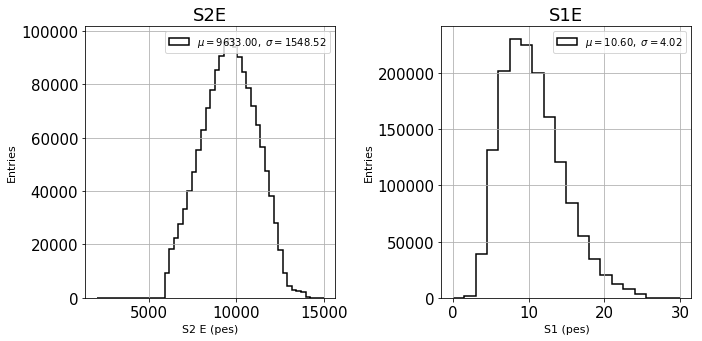

In [114]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.full.E, kdst.full.S1), bins=(krNBins.E, krNBins.S1), 
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 & S1 hard core

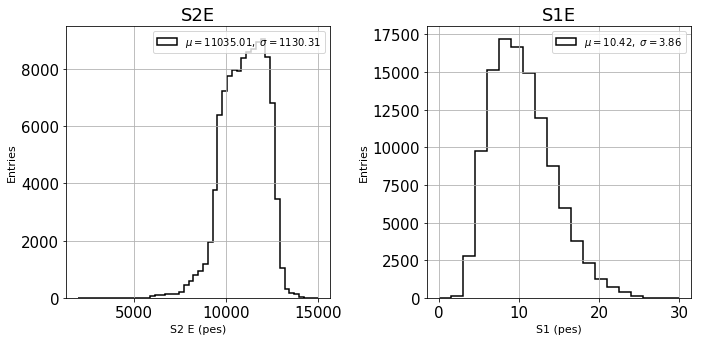

In [115]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.hcore.E, kdst.hcore.S1), bins=(krNBins.E, krNBins.S1), 
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 vs Z

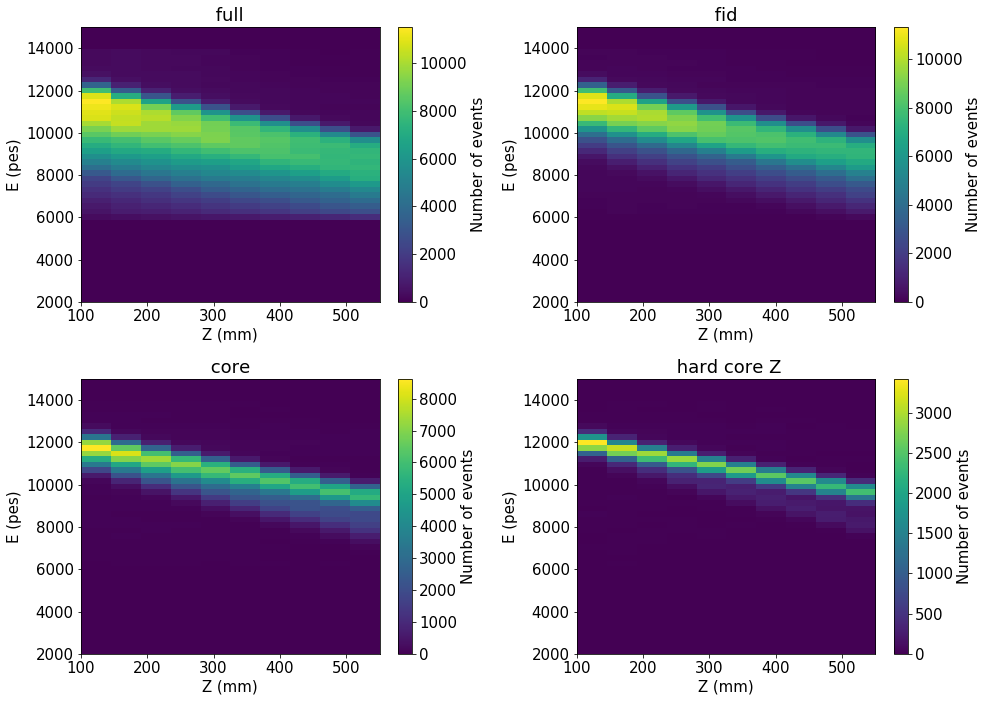

In [120]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit near center of chamber

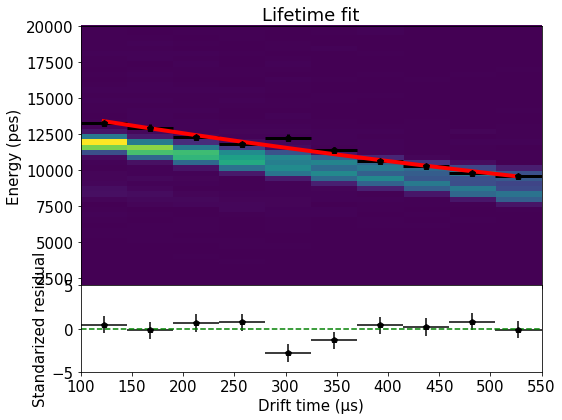

In [33]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kref, krNBins, krBins, krRanges, xyr)

In [34]:
krf.print_fit(kf)

 E (z=0) = 14847.244888475436 +-204.38783133256692 
 LT      = -1198.816046865111 +-55.243607659714385 
 chi2    = 0.9564244756686875 


### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
 E (z=0) = 13468.202873748094 +-300.88554478732124 
 LT      = -1394.865439319734 +-128.1118989909281 
 chi2    = 0.8176118190194464 
xlim = (-125, -75), ylim =(75, 125)
 E (z=0) = 12654.271420618332 +-259.78590750402464 
 LT      = -1100.4082812356028 +-70.9134471706328 
 chi2    = 1.2574435545042753 
xlim = (75, 125), ylim =(75, 125)
 E (z=0) = 11265.830144248197 +-190.25827955212674 
 LT      = -1515.834054720941 +-123.66421826371179 
 chi2    = 1.1784525348410833 
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11919.202812517755 +-195.19110332556914 
 LT      = -1639.5630243085766 +-124.55309868730616 
 chi2    = 0.7639987198013335 


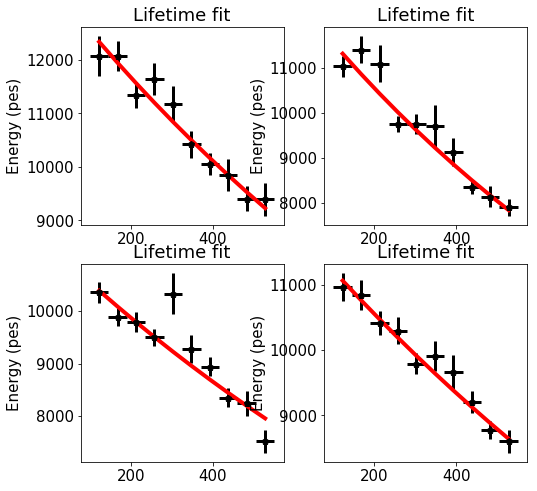

In [35]:
krf.lifetimes_in_XYRange(kred, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))

### Time profile of LT in the full detector

In [36]:
fits = krf.lifetimes_in_TRange(kred, krNBins, krBins, krRanges,  TL=TL)

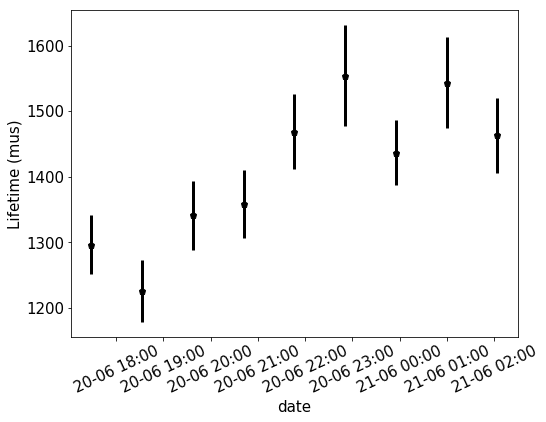

In [37]:
krp.plot_lifetime_T(fits, timeStamps)

### Time profile of LT in detector center

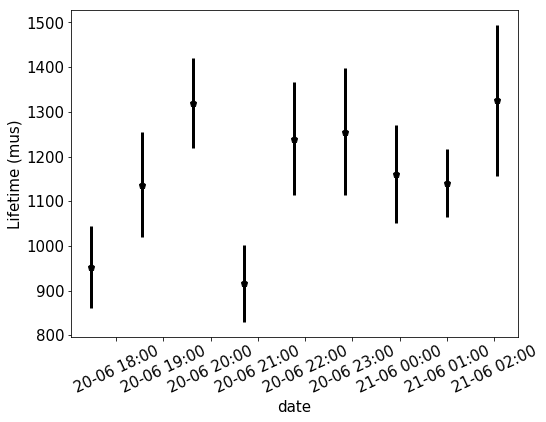

In [38]:
fits = krf.lifetimes_in_TRange(kref, krNBins, krBins, krRanges,  TL=TL)
krp.plot_lifetime_T(fits, timeStamps)

### Compute lifetime maps

In [39]:
krfs = krf.fit_lifetime_slices(kred, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [40]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [41]:
valid.shape

(30, 30)

In [42]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.7233333333333334

In [43]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =1388.6708651708923 +- 549.6012738937762
Lifetime uncertainty     : mu +- std =16.888139200562332 +- 9.135096663596553
Energy scale value       : mu +- std =12076.308864659897 +- 1447.3678055660882
Energy scale uncertainty : mu +- std =4.227219745348183 +- 1.795357066161473


In [44]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 8457.889350744677; E_max = 15694.728378575117
 Lifetime (ELT): ELT_min = 14.667680436451747; ELT_max = 2762.674049905333
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 8.715612410751866
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 39.72588085955371


### Map display

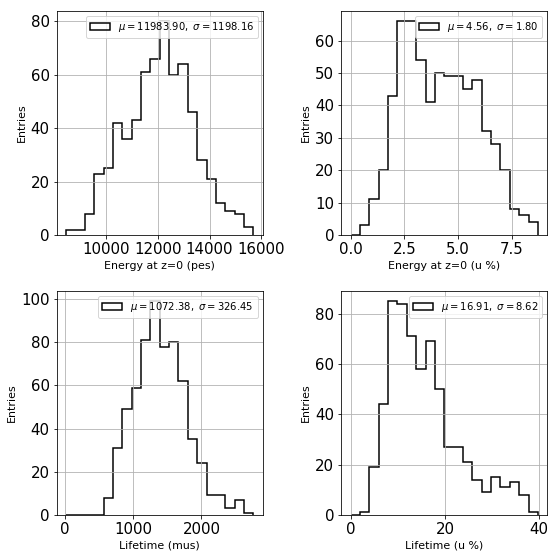

In [45]:
krh.h1n(4, 2, 2, (Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))


In [46]:
invalid = ~valid
mask = valid

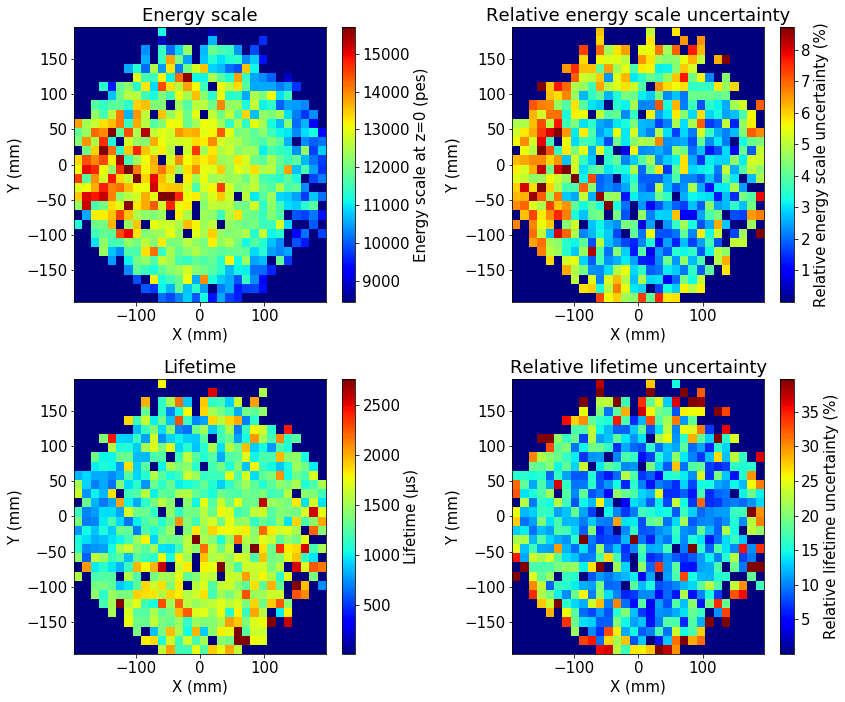

In [47]:
figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=valid)
                         

(1.4262662007303386, 0.63516025778629481)

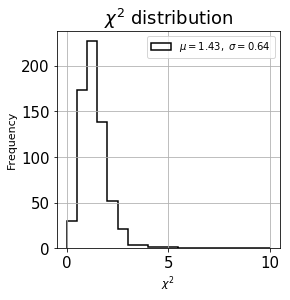

In [48]:
figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

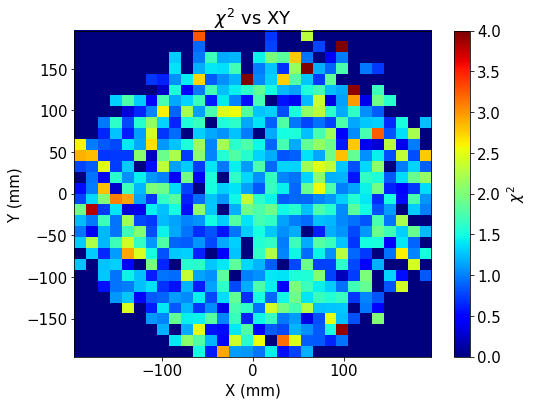

In [49]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

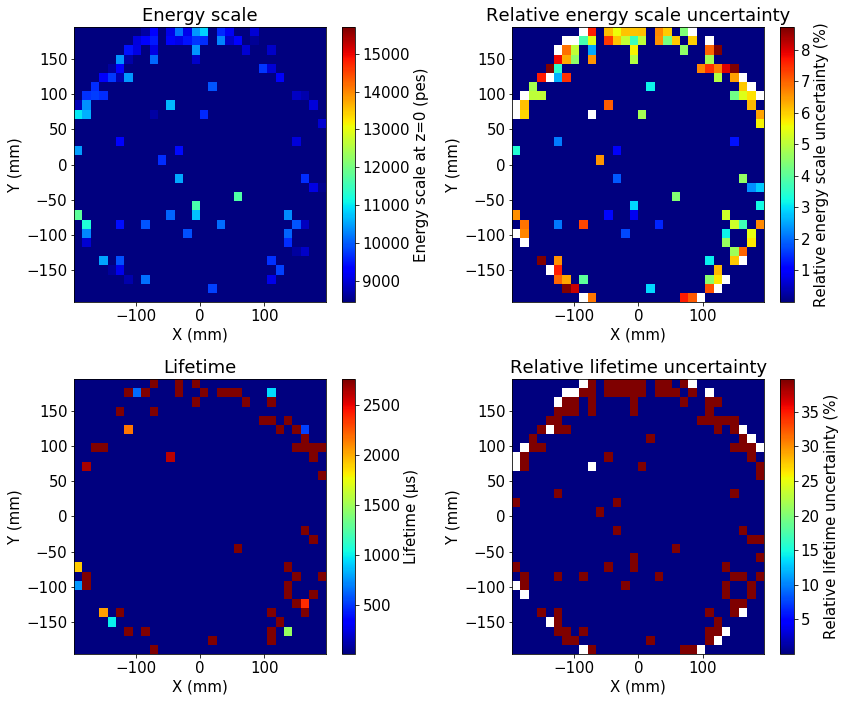

In [50]:
figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=invalid)

### Fix map

- Fill bins where fit has failed with average value of lifetime

In [51]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [52]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

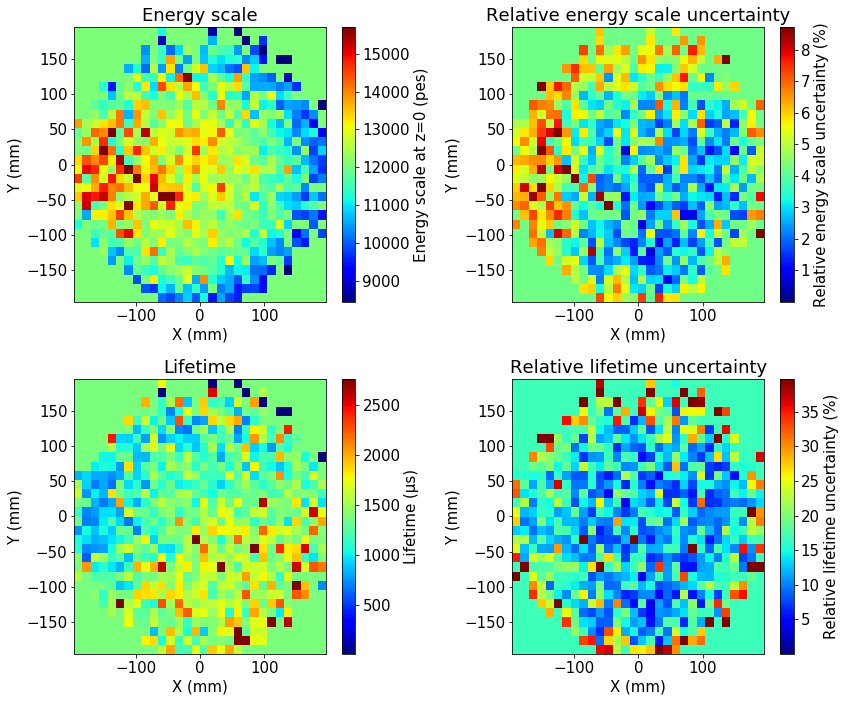

In [53]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, XYcenters, cmap="jet", mask=None)

### Produce HDF5 output

In [61]:
len(nevt)

30

In [62]:
with tb.open_file(output_dst_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch



### END